In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:

df = pd.read_csv("C:\Piyusha Kore\Third year\Projects\car_prediction\car data.csv")   # adjust path if needed
print("Shape of dataset:", df.shape)
print(df.head())


Shape of dataset: (301, 9)
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  


In [3]:
print(df.info())
print(df.describe())
print(df.isnull().sum()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Driven_kms     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Selling_type   301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None
              Year  Selling_Price  Present_Price     Driven_kms       Owner
count   301.000000     301.000000     301.000000     301.000000  301.000000
mean   2013.627907       4.661296       7.628472   36947.205980    0.043189
std       2.891554       5.082812       8.642584   38886.883882    0.247915
min    2003.000000       0.100000       

In [4]:
if "Car_Name" in df.columns:
    df["Brand"] = df["Car_Name"].apply(lambda x: x.split(" ")[0])
    df.drop("Car_Name", axis=1, inplace=True)

# Convert Year to Car_Age
if "Year" in df.columns:
    df["Car_Age"] = 2025 - df["Year"]
    df.drop("Year", axis=1, inplace=True)

df.head()

,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner,Brand,Car_Age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,ritz,11
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,sx4,12
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,ciaz,8
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,wagon,14
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,swift,11


In [5]:
target = "Selling_Price"   
X = df.drop(target, axis=1)
y = df[target]

print("Features:", X.columns)

Features: Index(['Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type',
       'Transmission', 'Owner', 'Brand', 'Car_Age'],
      dtype='object')


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (240, 8) Test size: (61, 8)


In [7]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [8]:
lr_model = Pipeline(steps=[("preprocessor", preprocessor),
                           ("regressor", LinearRegression())])
lr_model.fit(X_train, y_train)

rf_model = Pipeline(steps=[("preprocessor", preprocessor),
                           ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))])
rf_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
def evaluate(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    print(f"\n{name} Performance:")
    print("MAE :", mean_absolute_error(y_test, y_pred))
    print("MSE :", mean_squared_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2  :", r2_score(y_test, y_pred))

evaluate(lr_model, X_test, y_test, "Linear Regression")
evaluate(rf_model, X_test, y_test, "Random Forest")


Linear Regression Performance:
MAE : 1.063932459301089
MSE : 2.6645747705785916
RMSE: 1.6323525264410845
R2  : 0.8843278854838011

Random Forest Performance:
MAE : 0.6117901639344264
MSE : 0.8029299163934426
RMSE: 0.8960635671610818
R2  : 0.9651439313082677


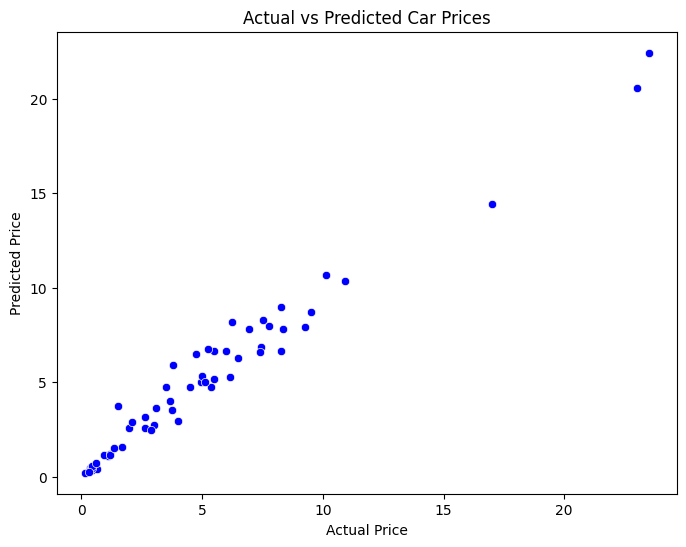

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = rf_model.predict(X_test)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, color="blue")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.show()

In [11]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())

Dataset Shape: (301, 9)

Columns: ['Selling_Price', 'Present_Price', 'Driven_kms', 'Fuel_Type', 'Selling_type', 'Transmission', 'Owner', 'Brand', 'Car_Age']

Missing Values:
 Selling_Price    0
Present_Price    0
Driven_kms       0
Fuel_Type        0
Selling_type     0
Transmission     0
Owner            0
Brand            0
Car_Age          0
dtype: int64

Summary Statistics:
        Selling_Price  Present_Price     Driven_kms       Owner     Car_Age
count     301.000000     301.000000     301.000000  301.000000  301.000000
mean        4.661296       7.628472   36947.205980    0.043189   11.372093
std         5.082812       8.642584   38886.883882    0.247915    2.891554
min         0.100000       0.320000     500.000000    0.000000    7.000000
25%         0.900000       1.200000   15000.000000    0.000000    9.000000
50%         3.600000       6.400000   32000.000000    0.000000   11.000000
75%         6.000000       9.900000   48767.000000    0.000000   13.000000
max        35.00000

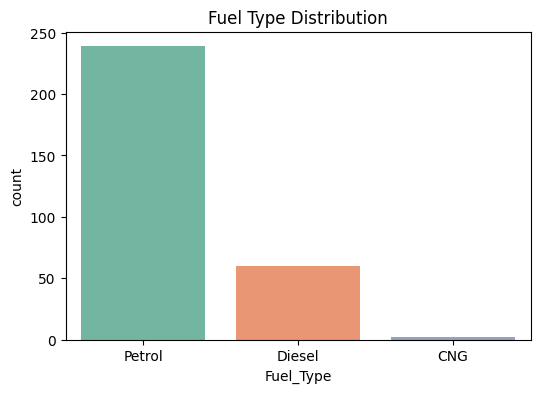

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x="Fuel_Type", data=df, palette="Set2")
plt.title("Fuel Type Distribution")
plt.show()

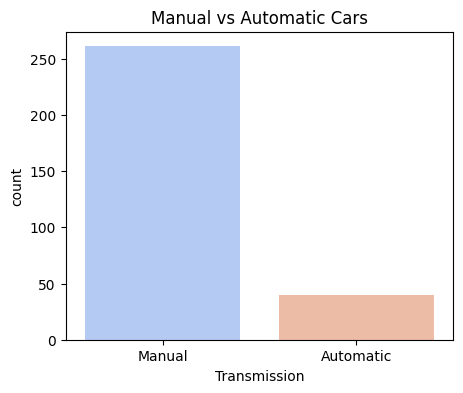

In [13]:
plt.figure(figsize=(5,4))
sns.countplot(x="Transmission", data=df, palette="coolwarm")
plt.title("Manual vs Automatic Cars")
plt.show()